# Ethereum price forcasting with linear regression

# AI, 딥러닝으로 주가를 예측할 수 있다고?

많은 딥러닝 입문 도서나 유튜브 콘텐츠 등에서 주가 예측을 소재로 삼는다. 자극적이고, 흥미롭기 때문이다. 심지어 예측 결과는 경이로울 정도로 정확해 보여서 주식도, 딥러닝도 잘 모르는 사람이라면 감탄을 금하지 못했을 것이다.

최근 딥러닝 도서, 강의를 통해 이런 결과물을 본 적이 있지 않은가?

![image](images/reg.png)

많이 의아했을 것이다. 만약 이게 가능하다면 투자를 하지 왜 강의를 하는 것이며, 왜 다른 기관투자자나 AI 개발자들은 이 기술을 쓰지 않는 것인지. 아니면 나만 모르고 있고 음지에서는 이미 99% 정확도의 돈 복사기를 돌리고 있는 게 아닐지.

자, 지금부터 이 비밀을 드러내 보일 것이다.

## Step 1. 시계열 데이터와 예측

시계열 데이터에는 '추세'라는 것이 있다. 매매 기술을 관심 있게 찾아본 적이 있다면 '추세 추종'같은 용어를 들어봤을 것이다. 그 추세가 맞다. 시계열 데이터를 분해해보면 '예측 가능한 영역'과 '예측 불가능한 영역'으로 나뉜다. 추세나 계절성 같은 것들이 바로 '예측 가능한 영역'이고 그런 것들을 모두 제거하면 '예측 불가능한 영역'이 된다. 예측 불가능하다는 것은 "이론적으로" 50:50이라는 뜻이다.

그래서 우리는 이 '예측 가능한 영역'을 가지고 모델을 학습시키고 싶지만 시계열 데이터는 그리 호락호락하지 않다. 시계열상 추세가 존재하면 데이터 간에는 '자기 상관성'이라는 게 생기게 되는데, 결론적으로 이 '자기 상관성' 때문에 예측 성능이 좋으면 좋을수록 오늘의 가격을 예측하면 어제 가격이 나오게 된다. 

![image](./images/deep_short_graph.png)

위 그래프는 본문 상단 이미지 중 일부로, LSTM(딥러닝 모델) 예측 결과다. 아주 단순한 모델로 짧은 시간 학습시킨 모델임에도 예측 성능이 좋아 보인다. 파란색 선이 예측한 가격, 초록색 선이 실제 가격인데 자세히 보면 예측 값이 실제 값보다 흡사한 형태로 1칸씩 밀린 것처럼 보이지 않는가? 이 경향은 모델 예측 성능을 높일수록(*주로 mean squared error라고 해서 실제값과 예측값의 오차를 줄이는 방식으로 성능을 높임) 뚜렷하게 나타난다.

## Step 2. 예측 실험

두 가지 실험을 진행할 것이다. 하나는 '딥러닝'이라서 이런 그래프를 그릴 수 있다는 것을 반증하기 위함이고, 다른 하나는 그래프상 예측력이 뛰어나 보이게 만드는 또 다른 이유를 보여주고자 함이다.

### Step 2-1. 예측 실험 A

딥러닝 주가 예측의 환상을 깨기위해 기계학습을 사용하지 않은 아주 단순한 통계 모형으로도 같은 결과를 만들 수 있다는 것을 보여주려 한다. 아래는 가장 기본적인 통계 분석 기법 중 하나인 '선형 회귀' 분석을 통해 예측한 결과다.

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
plt.style.use(['seaborn'])

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
ether_df = pd.read_csv('./data/ether_df.csv', index_col='date')
ether_df

,close,open,high,low,pc,volume
date,,,,,,
2021-12-27,4064.24,4062.02,4087.20,4049.39,0.07,252960.00
2021-12-26,4061.27,4093.38,4104.23,4005.38,-0.78,283580.00
2021-12-25,4093.14,4043.60,4136.03,4024.87,1.23,308530.00
2021-12-24,4043.39,4110.20,4133.77,4024.24,-1.62,353850.00
2021-12-23,4110.14,3979.57,4149.17,3895.89,3.28,573180.00
...,...,...,...,...,...,...
2016-03-14,12.50,15.07,15.07,11.40,-17.05,92180.00
2016-03-13,15.07,12.92,15.07,12.92,16.64,1300.00
2016-03-12,12.92,11.95,13.45,11.95,8.12,830.00


In [4]:
# 날짜(인덱스) 오름차순 정렬
ether_df.sort_index(inplace=True)

In [5]:
# 정규화된 데이터셋(윈도우's 리스트) 생성
window_size = 30
sequence_size = window_size + 1

dataset = []
for row in range(len(ether_df) - sequence_size + 1):
    # 각 윈도우 내 첫번째 가격(종가)을 0으로 조정하고,
    # 윈도우 내 전체 가격은 첫번째 가격 대비 상대적 차이로 정규화
    before_norm = ether_df['close'][row:row+sequence_size]
    first_p = before_norm[0]
    after_norm = [(comp_p/first_p)-1 for comp_p in before_norm]
    # numpy 벡터로 변환
    dataset.append(after_norm)

dataset = np.array(dataset)
len(dataset)


2089

In [6]:
limit_train = round(len(dataset)*0.8)
limit_valid = round(len(dataset)*0.9) 

train = dataset[:limit_train]
np.random.shuffle(train) # 벡터 위치 shuffle(각 벡터 형태는 유지)
train_X = train[:, :-1] # 각 벡터 마지막 값 직전까지(31일치 중 30일치 가격) 추출
train_y = train[:, -1] # 각 벡터 마지막 값(31일치 중 31일째 가격) 추출
 
valid = dataset[limit_train:limit_valid]
valid_X = valid[:, :-1]
valid_y = valid[:, -1]

test = dataset[limit_valid:]
test_X = test[:, :-1]
test_y = test[:, -1]

print(f'train set : {train_X.shape} {train_y.shape}')
print(f'valid set : {valid_X.shape} {valid_y.shape}')
print(f'test set : {test_X.shape} {test_y.shape}')

train set : (1671, 30) (1671,)
valid set : (209, 30) (209,)
test set : (209, 30) (209,)


In [7]:
lgbmr = LinearRegression()
lgbmr.fit(train_X, train_y)

LinearRegression()

In [8]:
pred = lgbmr.predict(test_X)

In [9]:
mean_squared_error(pred, test_y)

0.002446163654275503

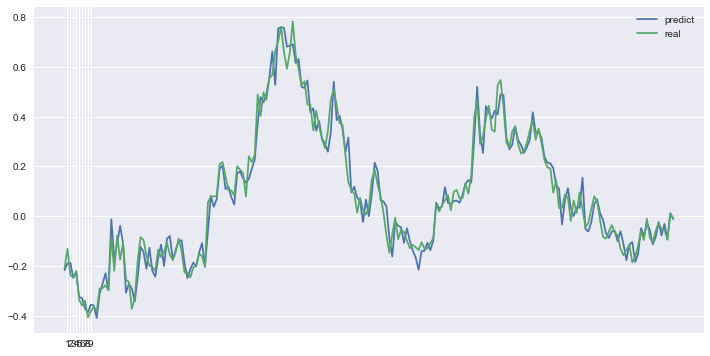

In [10]:
plt.figure(figsize=(12,6))

plt.plot(pred, label='predict')
plt.plot(test_y, label='real')
plt.legend()

plt.xticks(np.arange(1, 10, 1))
plt.show()

마찬가지로 초록색 선이 실제값, 파란색 선이 예측값이다. 이번에도 역시 전날 가격이 하루 밀려서 그대로 복사된 것처럼 보이는 구간이 있다.

![image](./images/reg_short_graph.png)

그러니 시중에 공개된 대부분의 딥러닝 주가 예측 튜토리얼도 가벼운 트릭일 뿐이다. 분명 흥미롭고 자극적인 소재로 공부하는 것은 많은 도움이 된다. 하지만 이 그래프가 무엇을 의미하는지 분명한 설명 없이 예측을 굉장히 잘한다는 식으로 결론짓고 끝내버리면 잘못된 정보가 된다. 우리는 잘못된 정보는 거르고 딥러닝으로 예측한다는 것이 어떤 방식으로 돌아가는지를 배워야지, 딥러닝으로 마법 같은 예측을 할 수 있다는 것에 현혹되지 말아야 할 것이다.

### 2-2. 예측 실험 B

다음으로 장기적으로 예측값은 결국 실제값을 따라 움직인다는 것을 보여주고자 한다. 이는 그래프가 그려지면서 매일매일의 오차가 100% 실제값으로 복원되기 때문이다. 다음은 30일 치로 하루를 예측하는 딱 그 순간을 포착한 부분이다.

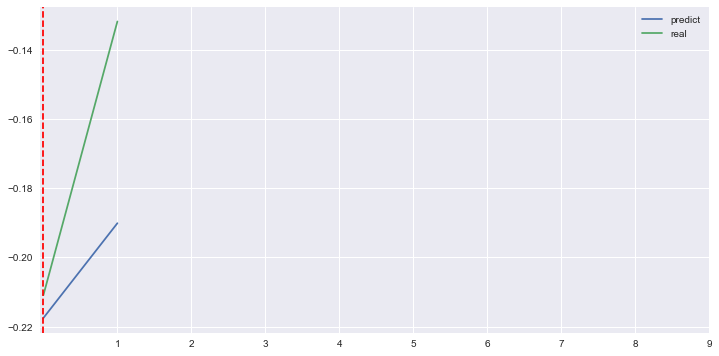

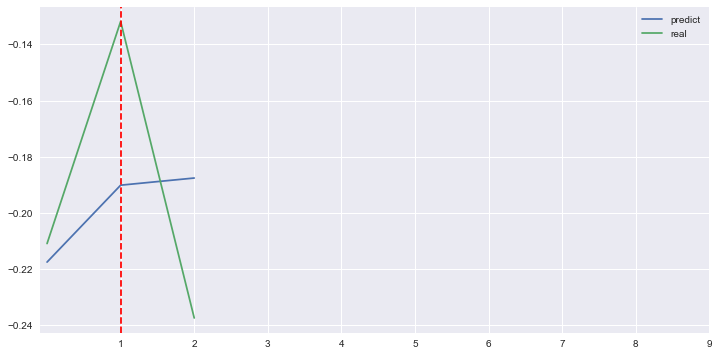

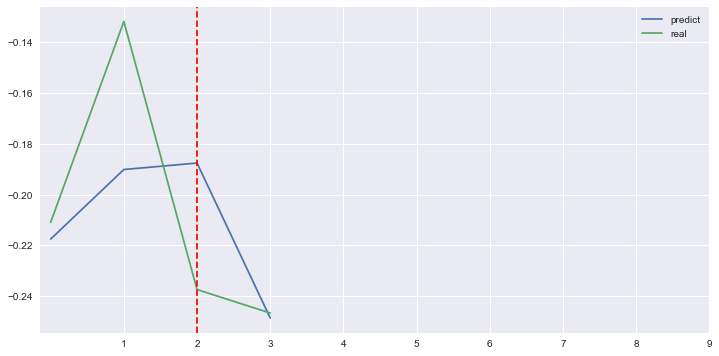

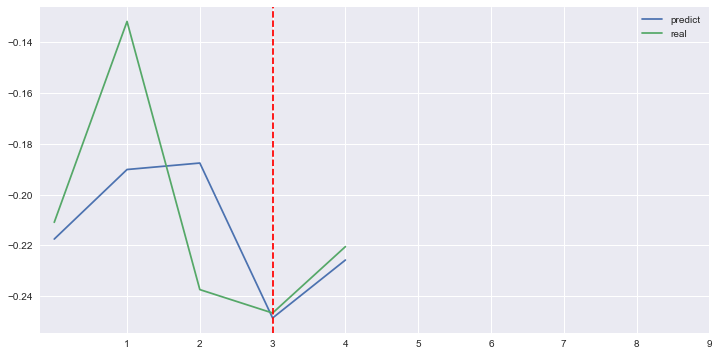

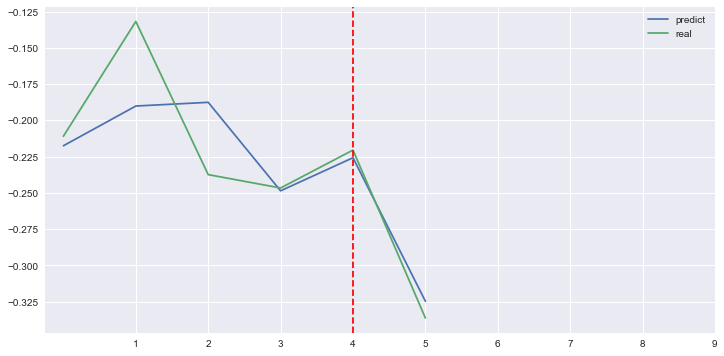

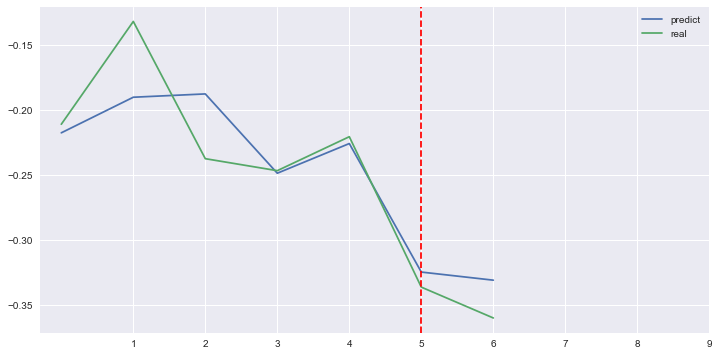

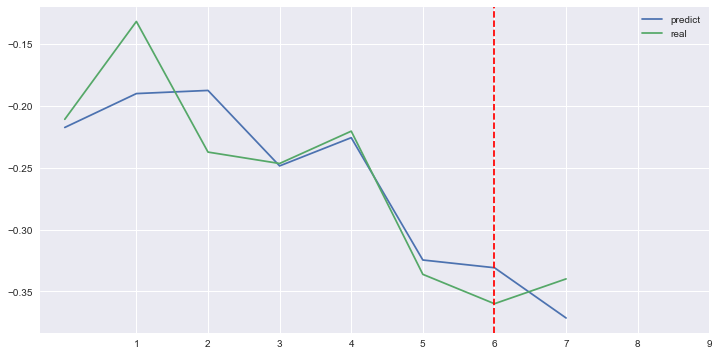

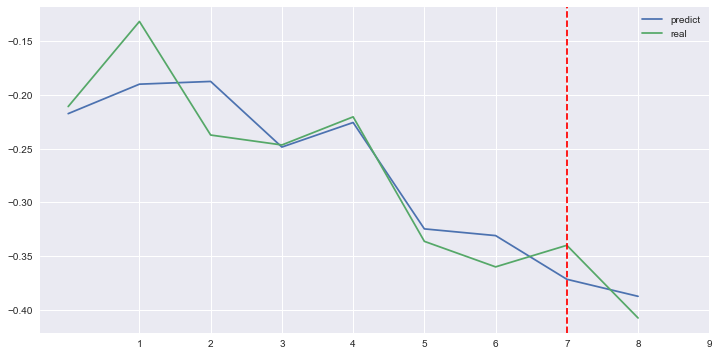

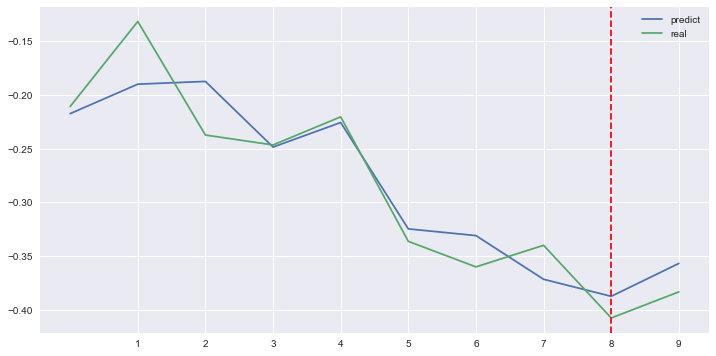

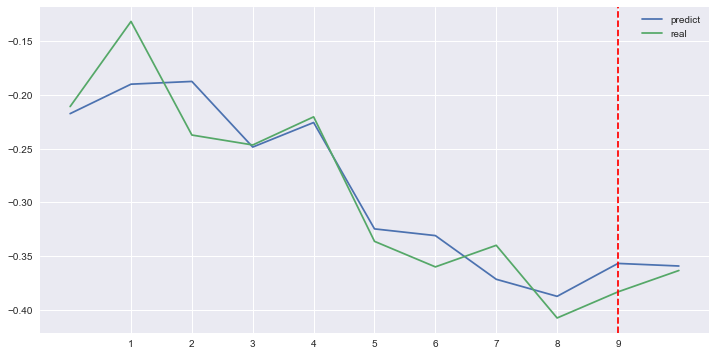

In [11]:
for i in range(10):
    plt.figure(figsize=(12,6))

    plt.plot(pred[:i+2], label='predict')
    plt.plot(test_y[:i+2], label='real')
    plt.legend()

    plt.xticks(np.arange(1, 10, 1))
    plt.axvline(x=i, c='r', linestyle='--')
    plt.show()

초록색 선은 실제 주가, 파란색 선은 예측한 주가다. 붉은 점선은 과거 30일 치 중 30일째. 그러니까 '어제'를 기준선으로 표시해주고 있다. 여기부터 시작해보자. 이제 모델이 다음 날을 예측할 때는 또다시 지난 30일을 가지고 예측하게 된다.

잘 보면 하루하루의 변화는 큰 폭으로 차이가 있는 것을 확인할 수 있다. 그렇게 반복하다 보면 아래와 같이 중간에 이동하는 방향이 일치하는 구간도 나타날 수 있지만 항상 그렇지 않다는 것이다. 

## Step 3. 결과 해석

![image](./images/reg.png)

그럼에도 불구하고 이렇게 길게 놓고 보면 결국은 장기적으로 같은 방향으로 그려질 수밖에 없다. 항상 '하루 전'을 기준으로 예측하기 때문이다. 그래서 하루만 봤을 때 방향이 엇갈리더라도 다음날을 예측할 때에는 엇갈린 데이터가 아니라 다시 실제 과거 30일을 가지고 예측하기 때문에 항상 실제값으로 조정하면서 그래프가 그려지는 것이다. 

문제를 단순화해서 예를 들면, 과거 5일 치 테슬라 종가가 [100, 200, 300, 400, 500]이었고 6일째를 600으로 예측했지만 실제로는 주가가 떨어져서 450이 되었다 해보자. 그럼 7일째는 과거 5일, 그러니까 2일째부터 해서 [200, 300, 400, 500, 600]을 가지고 예측하는 것이 아니라 [200, 300, 400, 500, 450]으로 예측하는 방식이다.

그래서 딥러닝이나 기타 통계기법으로 예측을 하는 경우 하루치 예측이라면 '하루'에 대한 예측 결과를, 10일 치 예측이라면 '10일 치'에 대한 예측 결과를 보는 것이 맞다. 이러한 의미에서 하루치 예측 결과를 모아서 장기 그래프를 그려놓고 보는 것은 눈속임에 불과하며 유의미한 인사이트를 얻는 데에 오히려 방해가 될 수 있다.